In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

# TS_Missing

In [3]:
# Load gradients for one modality (from the previous case)
one_modality_gradients = {}
for epoch in range(1, 9):
    file_path = f"/data/wang/junh/githubs/Multimodal-Transformer/w_gate_analysis/TS_Missing/TS_{epoch}.json"
    with open(file_path, 'r') as f:
        one_modality_gradients[epoch] = {k: np.array(v) for k, v in json.load(f).items()}

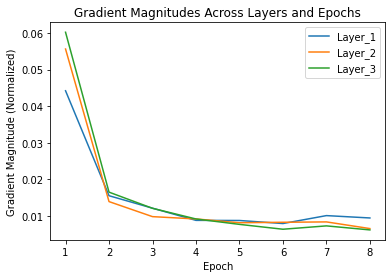

In [6]:
# Prepare data for visualization
epochs = list(range(1, 9))
layer_norms = {f"Layer_{i+1}": [] for i in range(3)}  # Assuming 3 layers

for epoch in epochs:
    for name, gradient in one_modality_gradients[epoch].items():
        if "layers.0" in name:
            layer_norms["Layer_1"].append(np.linalg.norm(gradient))  # Frobenius norm
        elif "layers.1" in name:
            layer_norms["Layer_2"].append(np.linalg.norm(gradient))
        elif "layers.2" in name:
            layer_norms["Layer_3"].append(np.linalg.norm(gradient))

# Plot gradient magnitudes for each layer
for layer, norms in layer_norms.items():
    plt.plot(epochs, norms, label=layer)

plt.xlabel("Epoch")
plt.ylabel("Gradient Magnitude (Normalized)")
plt.title("Gradient Magnitudes Across Layers and Epochs")
plt.legend()
plt.show()


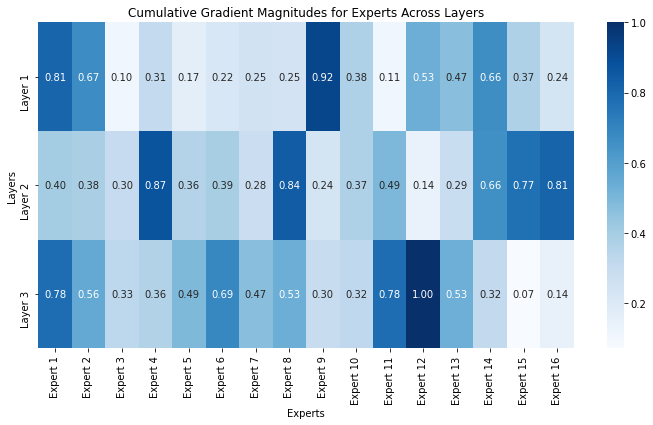

In [5]:
# Initialize the data structure for the heatmap
expert_gradients = np.zeros((3, 16))  # 3 layers (rows) x 16 experts (columns)

# Aggregate gradients for each layer and expert
for epoch in range(1, 9):  # Assuming 8 epochs
    for name, gradient in one_modality_gradients[epoch].items():
        if "layers.0" in name:
            expert_gradients[0, :] += np.mean(np.abs(gradient), axis=0)  # Layer 1
        elif "layers.1" in name:
            expert_gradients[1, :] += np.mean(np.abs(gradient), axis=0)  # Layer 2
        elif "layers.2" in name:
            expert_gradients[2, :] += np.mean(np.abs(gradient), axis=0)  # Layer 3

# Normalize the gradients (optional, for better visualization)
expert_gradients /= expert_gradients.max()

# Create the heatmap
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(expert_gradients, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=[f"Expert {i+1}" for i in range(16)],
            yticklabels=["Layer 1", "Layer 2", "Layer 3"])

plt.xlabel("Experts")
plt.ylabel("Layers")
plt.title("Cumulative Gradient Magnitudes for Experts Across Layers")
plt.show()

In [7]:
# Access the data from the heatmap
expert_gradients

array([[0.81103677, 0.66935425, 0.10428309, 0.31053981, 0.16745677,
        0.21701583, 0.24950749, 0.24507787, 0.92128441, 0.37519655,
        0.1051626 , 0.53409812, 0.4692349 , 0.66340021, 0.37016015,
        0.23843514],
       [0.40436167, 0.38357713, 0.30368709, 0.8707408 , 0.35665903,
        0.39090462, 0.28005719, 0.84292466, 0.23956814, 0.37464913,
        0.49472443, 0.13698886, 0.29177544, 0.65861704, 0.7699238 ,
        0.81390745],
       [0.778846  , 0.55643349, 0.3320291 , 0.36479772, 0.48867598,
        0.69017398, 0.46868349, 0.53429217, 0.29756642, 0.32275302,
        0.78024714, 1.        , 0.53021767, 0.31517545, 0.07142044,
        0.14060199]])

# TS_Text

In [9]:
# Load gradients for two modalities
two_modality_gradients = {}
for epoch in range(1, 9):  # 8 epochs
    file_path = f"/data/wang/junh/githubs/Multimodal-Transformer/w_gate_analysis/TS_Text_Missing/TS_Text_{epoch}.json"
    with open(file_path, 'r') as f:
        # Example structure: {layer_modality: gradient array}
        two_modality_gradients[epoch] = {k: np.array(v) for k, v in json.load(f).items()}

# Load gradients for one modality (from the previous case)
one_modality_gradients = {}
for epoch in range(1, 9):
    file_path = f"/data/wang/junh/githubs/Multimodal-Transformer/w_gate_analysis/TS_Missing/TS_{epoch}.json"
    with open(file_path, 'r') as f:
        one_modality_gradients[epoch] = {k: np.array(v) for k, v in json.load(f).items()}

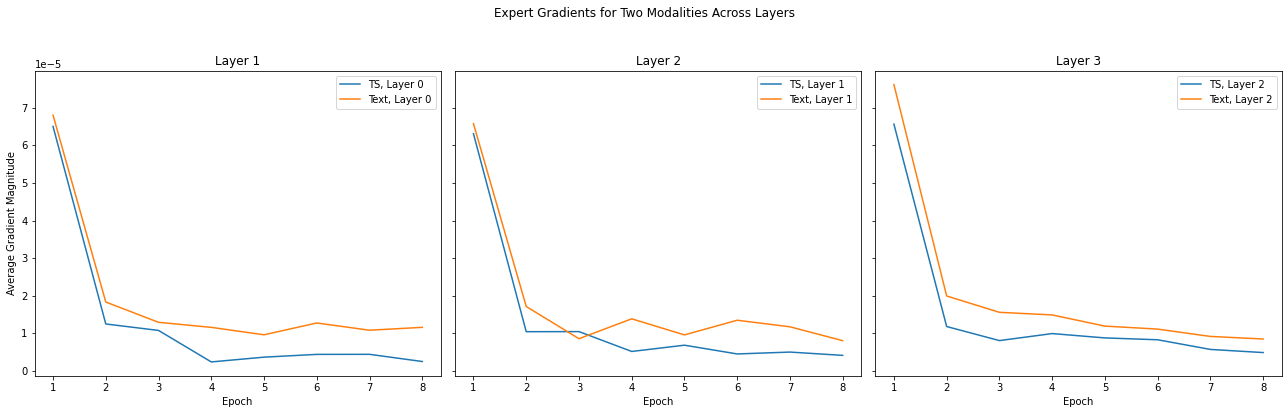

In [15]:
# Define the calculation function
def calculate_expert_averages(gradients, modality, layer):
    expert_averages = []
    for epoch in range(1, 9):  # Assuming there are 8 epochs
        for name, grad in gradients[epoch].items():
            if modality in name and f"layers.{layer}" in name:
                avg_grad = np.mean(np.abs(grad), axis=0)  # Average over tokens
                expert_averages.append(avg_grad)
    return np.array(expert_averages)  # Shape: (epochs, experts)

# Initialize the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Expert Gradients for Two Modalities Across Layers')

# Layer indices for the plot
layers = [0, 1, 2]
modalities = ["w_gate.0", "w_gate.1"]  # Assume two modalities
modality_labels = ["TS", "Text"]

# Iterate over each layer
for i, layer in enumerate(layers):
    for j, modality in enumerate(modalities):
        # Calculate expert averages
        modality_experts = calculate_expert_averages(two_modality_gradients, modality, layer)

        # Plot
        axes[i].plot(range(1, 9), np.mean(modality_experts, axis=1), label=f"{modality_labels[j]}, Layer {layer}")

    axes[i].set_title(f"Layer {layer + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Average Gradient Magnitude")
    axes[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to fit the overall title
plt.show()


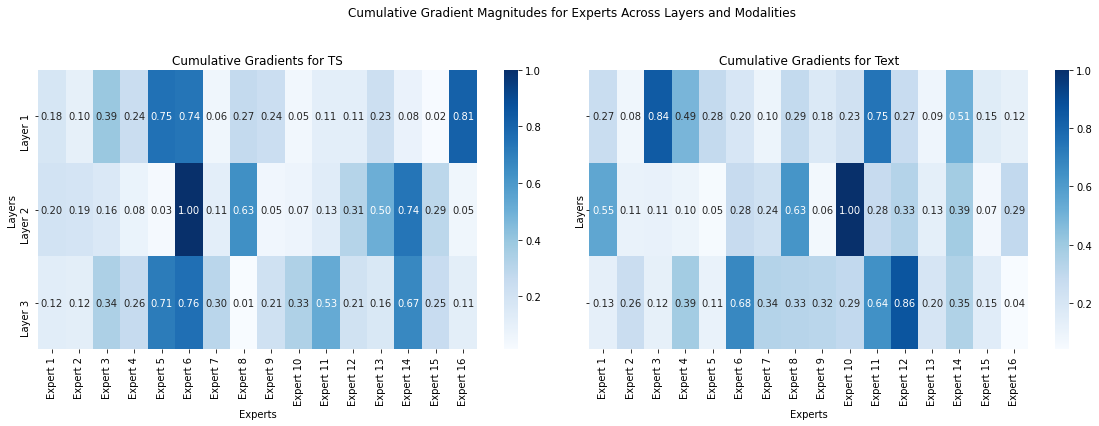

In [14]:
# Initialize the data structures for the heatmap, one for each modality
expert_gradients_modality_1 = np.zeros((3, 16))  # 3 layers (rows) x 16 experts (columns)
expert_gradients_modality_2 = np.zeros((3, 16))

# Modality identifiers in parameter names
modalities = ["w_gate.0", "w_gate.1"]

# Aggregate gradients for each layer and expert for each modality
for modality, expert_gradients in zip(modalities, [expert_gradients_modality_1, expert_gradients_modality_2]):
    for epoch in range(1, 9):  # Assuming 8 epochs
        for name, gradient in two_modality_gradients[epoch].items():
            if modality in name:
                if "layers.0" in name:
                    expert_gradients[0, :] += np.mean(np.abs(gradient), axis=0)  # Layer 1
                elif "layers.1" in name:
                    expert_gradients[1, :] += np.mean(np.abs(gradient), axis=0)  # Layer 2
                elif "layers.2" in name:
                    expert_gradients[2, :] += np.mean(np.abs(gradient), axis=0)  # Layer 3

# Normalize the gradients for better visualization
expert_gradients_modality_1 /= expert_gradients_modality_1.max()
expert_gradients_modality_2 /= expert_gradients_modality_2.max()

# Set up a subplot grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Share y-axis for comparable scale

# Create the heatmap for each modality
sns.heatmap(expert_gradients_modality_1, annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=axes[0],
            xticklabels=[f"Expert {i+1}" for i in range(16)],
            yticklabels=["Layer 1", "Layer 2", "Layer 3"])
axes[0].set_title("Cumulative Gradients for TS")
axes[0].set_xlabel("Experts")
axes[0].set_ylabel("Layers")

sns.heatmap(expert_gradients_modality_2, annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=axes[1],
            xticklabels=[f"Expert {i+1}" for i in range(16)],
            yticklabels=["Layer 1", "Layer 2", "Layer 3"])
axes[1].set_title("Cumulative Gradients for Text")
axes[1].set_xlabel("Experts")
axes[1].set_ylabel("Layers")

plt.suptitle("Cumulative Gradient Magnitudes for Experts Across Layers and Modalities")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the title
plt.show()

In [11]:
expert_gradients_modality_1

array([[0.17724751, 0.10010205, 0.39097212, 0.24329409, 0.75293404,
        0.73508801, 0.05506276, 0.26655984, 0.23639534, 0.04681845,
        0.11068313, 0.1105835 , 0.22938695, 0.07979537, 0.01950167,
        0.8131458 ],
       [0.20065931, 0.18694029, 0.15823643, 0.07648145, 0.02832032,
        1.        , 0.10930699, 0.63374367, 0.04804192, 0.06608816,
        0.12651101, 0.31154396, 0.50440184, 0.73519093, 0.2923356 ,
        0.05440026],
       [0.12176301, 0.11530435, 0.34046026, 0.26027335, 0.71153902,
        0.75819473, 0.29713748, 0.01286008, 0.21370322, 0.33236036,
        0.52533114, 0.2068999 , 0.16238907, 0.66536469, 0.24851812,
        0.11486783]])

In [12]:
expert_gradients_modality_2

array([[0.2687629 , 0.08076155, 0.84228386, 0.48698152, 0.28466002,
        0.19536598, 0.09600616, 0.28996264, 0.17738179, 0.23360981,
        0.74757614, 0.26984888, 0.08635769, 0.51326519, 0.15406153,
        0.12461426],
       [0.5549333 , 0.1081459 , 0.11178161, 0.09637161, 0.04825913,
        0.27914572, 0.23746665, 0.62663346, 0.06477176, 1.        ,
        0.27675807, 0.33448474, 0.1322584 , 0.38601262, 0.06805655,
        0.29388236],
       [0.12933188, 0.26274483, 0.12477348, 0.38850282, 0.1096042 ,
        0.67754086, 0.33527638, 0.32824521, 0.31537709, 0.29352355,
        0.64316741, 0.86257745, 0.2047692 , 0.34625307, 0.15060365,
        0.04050408]])